In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath("../../function"))
from others import haversine, NSE, relative_error, spearman_corr, MAE, RMSE, MBE

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil')

In [3]:
full_time = pd.date_range(start="2024-03-01 00:00", end="2024-12-31 23:00", freq="1H")
print(f'Number of times: {len(full_time)}')

Number of times: 7344


In [4]:
# DATA = xr.open_dataset('/media/arturo/Arturo/Data/Brazil/GSMaP/NOW/GSMaP_NOW_SA_1h_2024_01_01_2024_12_31.nc')
DATA = xr.open_dataset('/media/arturo/Arturo/Data/Brazil/GSMaP/NOW/GSMaP_NOW_BR_1h_2024_01_01_2024_12_31.nc')
# DATA = DATA.sel(time=slice("2024-03-01", "2024-12-31"))
lon2d, lat2d = np.meshgrid(DATA.lon.values, DATA.lat.values)
GSMaP_NOW = DATA.PRE.values
GSMaP_NOW.shape

(8784, 420, 419)

In [5]:
# DATA = xr.open_dataset('/media/arturo/Arturo/Data/Brazil/GSMaP/NRT/GSMaP_NRT_SA_1h_2024_01_01_2024_12_31.nc')
DATA = xr.open_dataset('/media/arturo/Arturo/Data/Brazil/GSMaP/NRT/GSMaP_NRT_BR_1h_2024_01_01_2024_12_31.nc')
# DATA = DATA.sel(time=slice("2024-03-01", "2024-12-31"))
lon2d, lat2d = np.meshgrid(DATA.lon.values, DATA.lat.values)
GSMaP_NRT = DATA.PRE.values
GSMaP_NRT.shape

(8784, 420, 419)

In [6]:
del DATA

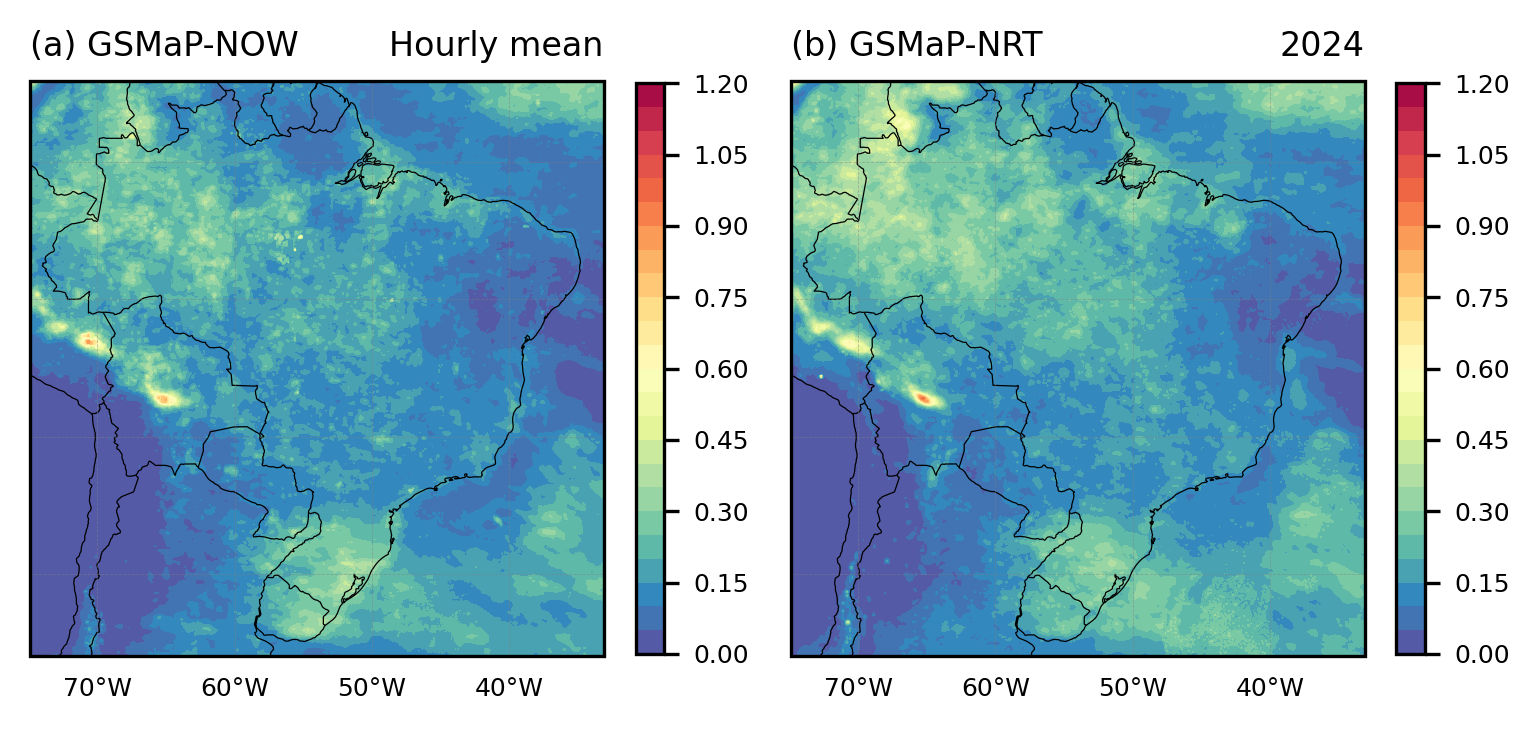

In [7]:
levels = np.arange(0,1.25,0.05)

cmap = plt.cm.Spectral_r

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-87,-30,-50,15],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.3, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(GSMaP_NOW,axis=0),levels=levels, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.05, fraction=0.045)
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(a) GSMaP-NOW', loc='left', fontsize=8)
ax1.set_title('Hourly mean', loc='right', fontsize=8)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([-87,-30,-50,15],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.3, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d, lat2d, np.nanmean(GSMaP_NRT,axis=0),levels=levels, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.05, fraction=0.045)
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(b) GSMaP-NRT', loc='left', fontsize=8)
ax1.set_title('2024', loc='right', fontsize=8)

#==================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [8]:
INEMET_INFO = pd.read_csv(os.path.join(dir_base,'INEMET','METADATA_2024.csv'))
INEMET_INFO.head(4)

,FILE,UF,LAT,LON
0,INMET_CO_DF_A001_BRASILIA_01-01-2024_A_31-12-2...,DF,-15.789444,-47.925833
1,INMET_CO_DF_A042_BRAZLANDIA_01-01-2024_A_31-12...,DF,-15.599722,-48.131111
2,INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2024_A_...,DF,-15.596491,-47.625801
3,INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2024_...,DF,-15.935278,-48.137500


In [57]:
RMSE_GSMaP_NOW, COR_GSMaP_NOW, NSE_GSMaP_NOW, MAE_GSMaP_NOW, RE_GSMaP_NOW, MRE_GSMaP_NOW = [], [], [], [], [], []
RAIN_GSMaP_NOW = []

lat_ref, lon_ref = [], []

for nn in range(len(INEMET_INFO)):

    obs = pd.read_csv(os.path.join(dir_base,'INEMET','1h','2024',INEMET_INFO['FILE'].values[nn]))
    obs['datetime'] = pd.to_datetime(obs['datetime'])

    start = '2024-01-01 00:00'
    end = '2024-12-31 23:00'
    obs_filtered = obs[(obs['datetime'] >= start) & (obs['datetime'] <= end)]
    obs_filtered = obs_filtered.reset_index(drop=True)

    PRE_obs = obs_filtered['PRE'].values

    lat_obs = INEMET_INFO['LAT'].values[nn]
    lon_obs = INEMET_INFO['LON'].values[nn]
    lat_ref.append(INEMET_INFO['LAT'].values[nn])
    lon_ref.append(INEMET_INFO['LON'].values[nn])
    
    distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PRE_sat = GSMaP_NOW[:,min_index[0],min_index[1]]
    PRE_sat_rdy = PRE_sat[~np.isnan(PRE_obs)]
    PRE_obs_rdy = PRE_obs[~np.isnan(PRE_obs)]
    RAIN_GSMaP_NOW.append(PRE_sat_rdy)
    
    RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)
    COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)
    NSE_tmp = NSE(PRE_sat_rdy,PRE_obs_rdy)
    MAE_tmp = MBE(PRE_sat_rdy,PRE_obs_rdy)
    RE_tmp = relative_error(PRE_sat_rdy,PRE_obs_rdy)

    RMSE_GSMaP_NOW.append(float(RMSE_tmp))
    COR_GSMaP_NOW.append(float(COR_tmp))
    NSE_GSMaP_NOW.append(float(NSE_tmp))
    MAE_GSMaP_NOW.append(float(MAE_tmp))
    RE_GSMaP_NOW.append(RE_tmp)
    MRE_GSMaP_NOW.append(float(np.nanmean(RE_tmp)))

RE_GSMaP_NOW = [item for matriz in RE_GSMaP_NOW for item in matriz.flatten()]
RAIN_GSMaP_NOW = [item for matriz in RAIN_GSMaP_NOW for item in matriz.flatten()]

In [58]:
RMSE_GSMaP_NRT, COR_GSMaP_NRT, NSE_GSMaP_NRT, MAE_GSMaP_NRT, RE_GSMaP_NRT, MRE_GSMaP_NRT = [], [], [], [], [], []
RAIN_GSMaP_NRT = []

lat_ref, lon_ref = [], []

for nn in range(len(INEMET_INFO)):

    obs = pd.read_csv(os.path.join(dir_base,'INEMET','1h','2024',INEMET_INFO['FILE'].values[nn]))
    obs['datetime'] = pd.to_datetime(obs['datetime'])

    start = '2024-01-01 00:00'
    end = '2024-12-31 23:00'
    obs_filtered = obs[(obs['datetime'] >= start) & (obs['datetime'] <= end)]
    obs_filtered = obs_filtered.reset_index(drop=True)

    PRE_obs = obs_filtered['PRE'].values

    lat_obs = INEMET_INFO['LAT'].values[nn]
    lon_obs = INEMET_INFO['LON'].values[nn]
    lat_ref.append(INEMET_INFO['LAT'].values[nn])
    lon_ref.append(INEMET_INFO['LON'].values[nn])
    
    distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PRE_sat = GSMaP_NRT[:,min_index[0],min_index[1]]
    PRE_sat_rdy = PRE_sat[~np.isnan(PRE_obs)]
    PRE_obs_rdy = PRE_obs[~np.isnan(PRE_obs)]
    RAIN_GSMaP_NRT.append(PRE_sat_rdy)
    
    RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)
    COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)
    NSE_tmp = NSE(PRE_sat_rdy,PRE_obs_rdy)
    MAE_tmp = MBE(PRE_sat_rdy,PRE_obs_rdy)
    RE_tmp = relative_error(PRE_sat_rdy,PRE_obs_rdy)

    RMSE_GSMaP_NRT.append(float(RMSE_tmp))
    COR_GSMaP_NRT.append(float(COR_tmp))
    NSE_GSMaP_NRT.append(float(NSE_tmp))
    MAE_GSMaP_NRT.append(float(MAE_tmp))
    RE_GSMaP_NRT.append(RE_tmp)
    MRE_GSMaP_NRT.append(float(np.nanmean(RE_tmp)))

RE_GSMaP_NRT = [item for matriz in RE_GSMaP_NRT for item in matriz.flatten()]
RAIN_GSMaP_NRT = [item for matriz in RAIN_GSMaP_NRT for item in matriz.flatten()]

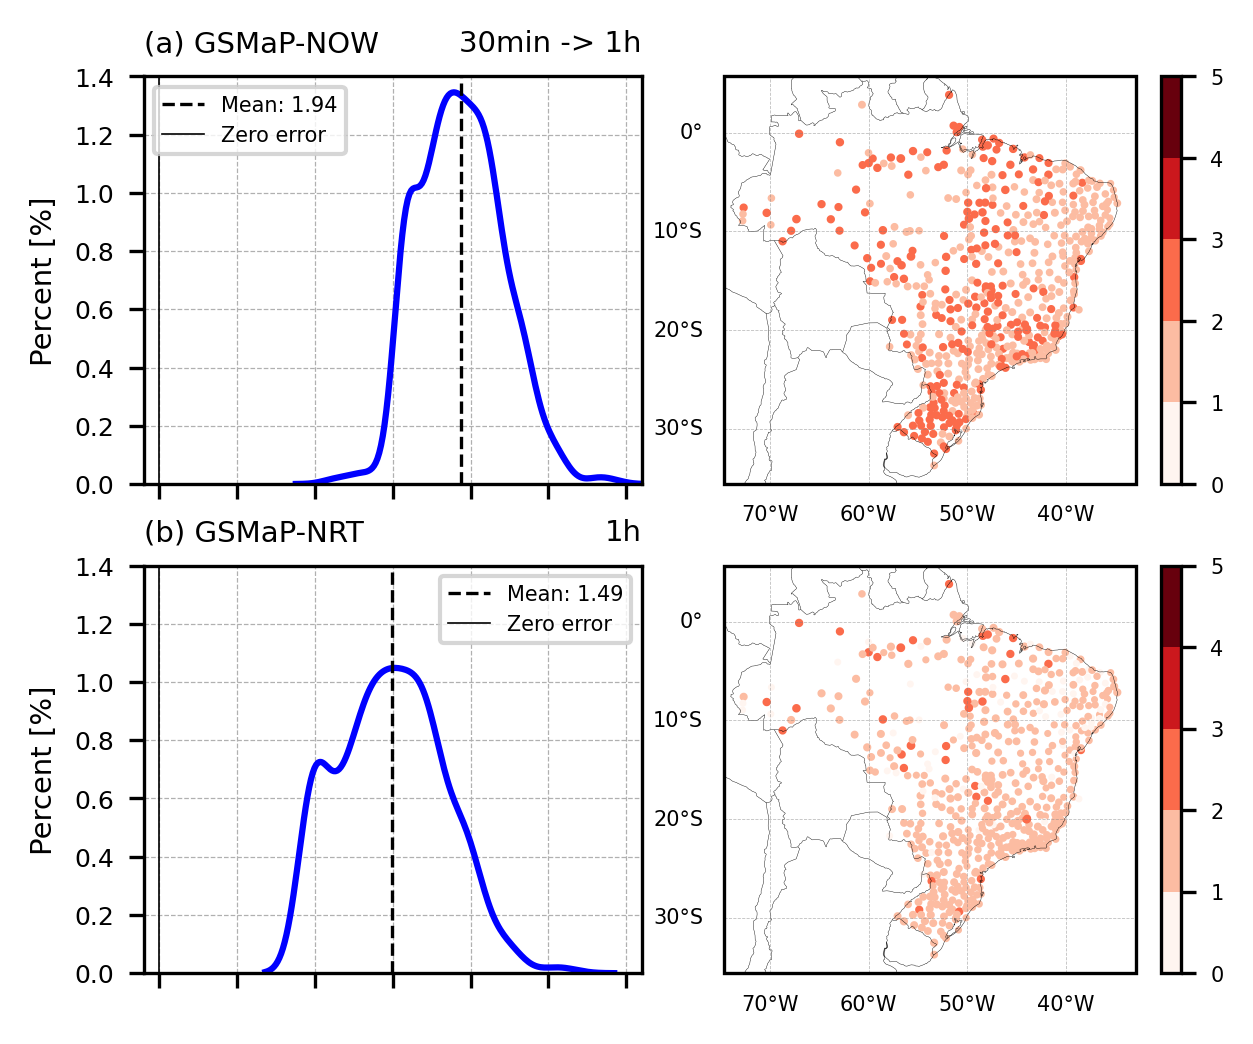

In [23]:
levels = np.arange(0, 6, 1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Reds

fig = plt.figure(figsize=(4.5,6),dpi=300)
gs = gridspec.GridSpec(3,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RMSE_GSMaP_NOW,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RMSE_GSMaP_NOW),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(RMSE_GSMaP_NOW),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-0.1,3.1)
ax1.set_ylim(0,1.4)
ax1.set_xticks(np.arange(0, 3.1, 0.5))
ax1.set_xticklabels([])
ax1.set_title('(a) GSMaP-NOW', loc='left', fontsize=7)
ax1.set_title('30min -> 1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=2)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(RMSE_GSMaP_NOW/np.nanmax(RMSE_GSMaP_NOW)),marker='.',c=RMSE_GSMaP_NOW,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(RMSE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RMSE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RMSE_GSMaP_NRT),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
# ax1.set_xlabel('Root Mean Square Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-0.1,3.1)
ax1.set_ylim(0,1.4)
ax1.set_xticks(np.arange(0, 3.1, 0.5))
ax1.set_xticklabels([])
ax1.set_title('(b) GSMaP-NRT', loc='left', fontsize=7)
ax1.set_title('1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(RMSE_GSMaP_NRT/np.nanmax(RMSE_GSMaP_NRT)),marker='.',c=RMSE_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

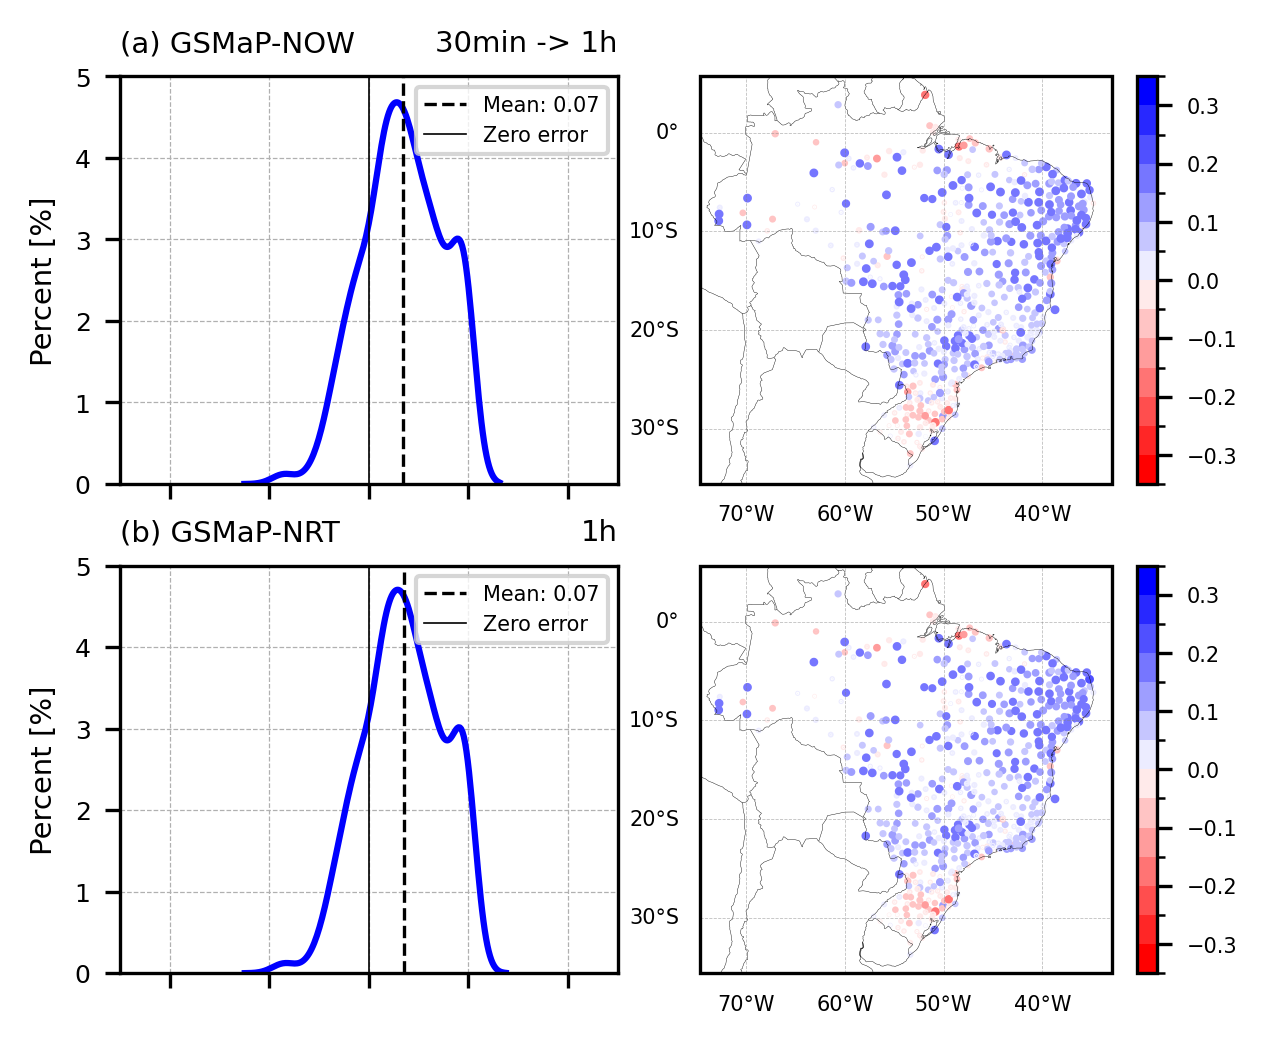

In [27]:
levels = np.arange(-0.35, 0.4, 0.05)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.bwr_r

fig = plt.figure(figsize=(4.5,6),dpi=300)
gs = gridspec.GridSpec(3,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(MAE_GSMaP_NOW,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(MAE_GSMaP_NOW),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(MAE_GSMaP_NOW),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim(0,5)
ax1.set_xticklabels([])
ax1.set_title('(a) GSMaP-NOW', loc='left', fontsize=7)
ax1.set_title('30min -> 1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MAE_GSMaP_NOW/np.nanmax(MAE_GSMaP_NOW)),marker='.',c=MAE_GSMaP_NOW,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(MAE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(MAE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(MAE_GSMaP_NRT),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
# ax1.set_xlabel('Mean Bias Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim(0,5)
ax1.set_xticklabels([])
ax1.set_title('(b) GSMaP-NRT', loc='left', fontsize=7)
ax1.set_title('1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MAE_GSMaP_NRT/np.nanmax(MAE_GSMaP_NRT)),marker='.',c=MAE_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

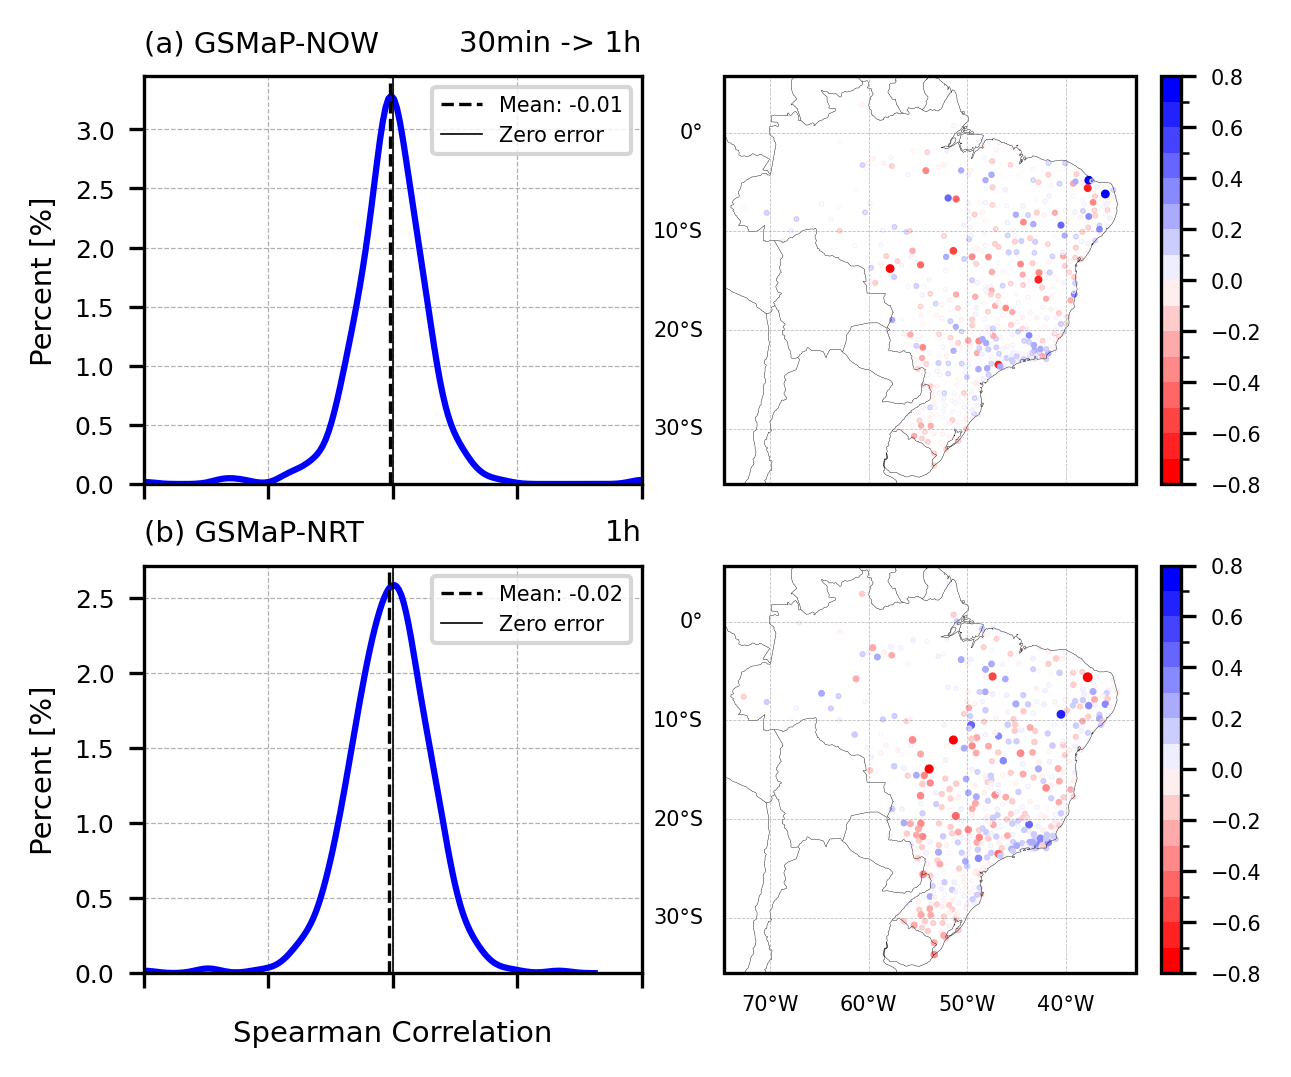

In [35]:
levels = np.arange(-0.8, 0.9, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.bwr_r

fig = plt.figure(figsize=(4.5,6),dpi=300)
gs = gridspec.GridSpec(3,2)
#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(COR_GSMaP_NOW,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(COR_GSMaP_NOW),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(COR_GSMaP_NOW),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-1,1)
ax1.set_xticklabels([])
ax1.set_title('(a) GSMaP-NOW', loc='left', fontsize=7)
ax1.set_title('30min -> 1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(COR_GSMaP_NOW/np.nanmax(COR_GSMaP_NOW)),marker='.',c=COR_GSMaP_NOW,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(COR_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(COR_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(COR_GSMaP_NRT),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Spearman Correlation',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-1,1)
ax1.set_xticklabels([])
ax1.set_title('(b) GSMaP-NRT', loc='left', fontsize=7)
ax1.set_title('1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(COR_GSMaP_NRT/np.nanmax(COR_GSMaP_NRT)),marker='.',c=COR_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [60]:
MRE_GSMaP_NOW = np.array(MRE_GSMaP_NOW)
MRE_GSMaP_NOW[MRE_GSMaP_NOW>15] = np.nan

MRE_GSMaP_NRT = np.array(MRE_GSMaP_NRT)
MRE_GSMaP_NRT[MRE_GSMaP_NRT>15] = np.nan

print(np.nanmin(MRE_GSMaP_NOW), np.nanmax(MRE_GSMaP_NOW))
print(np.nanmin(MRE_GSMaP_NRT), np.nanmax(MRE_GSMaP_NRT))

-0.9749999990065893 7.54272851097927
-0.9972506694030017 8.90165696936097


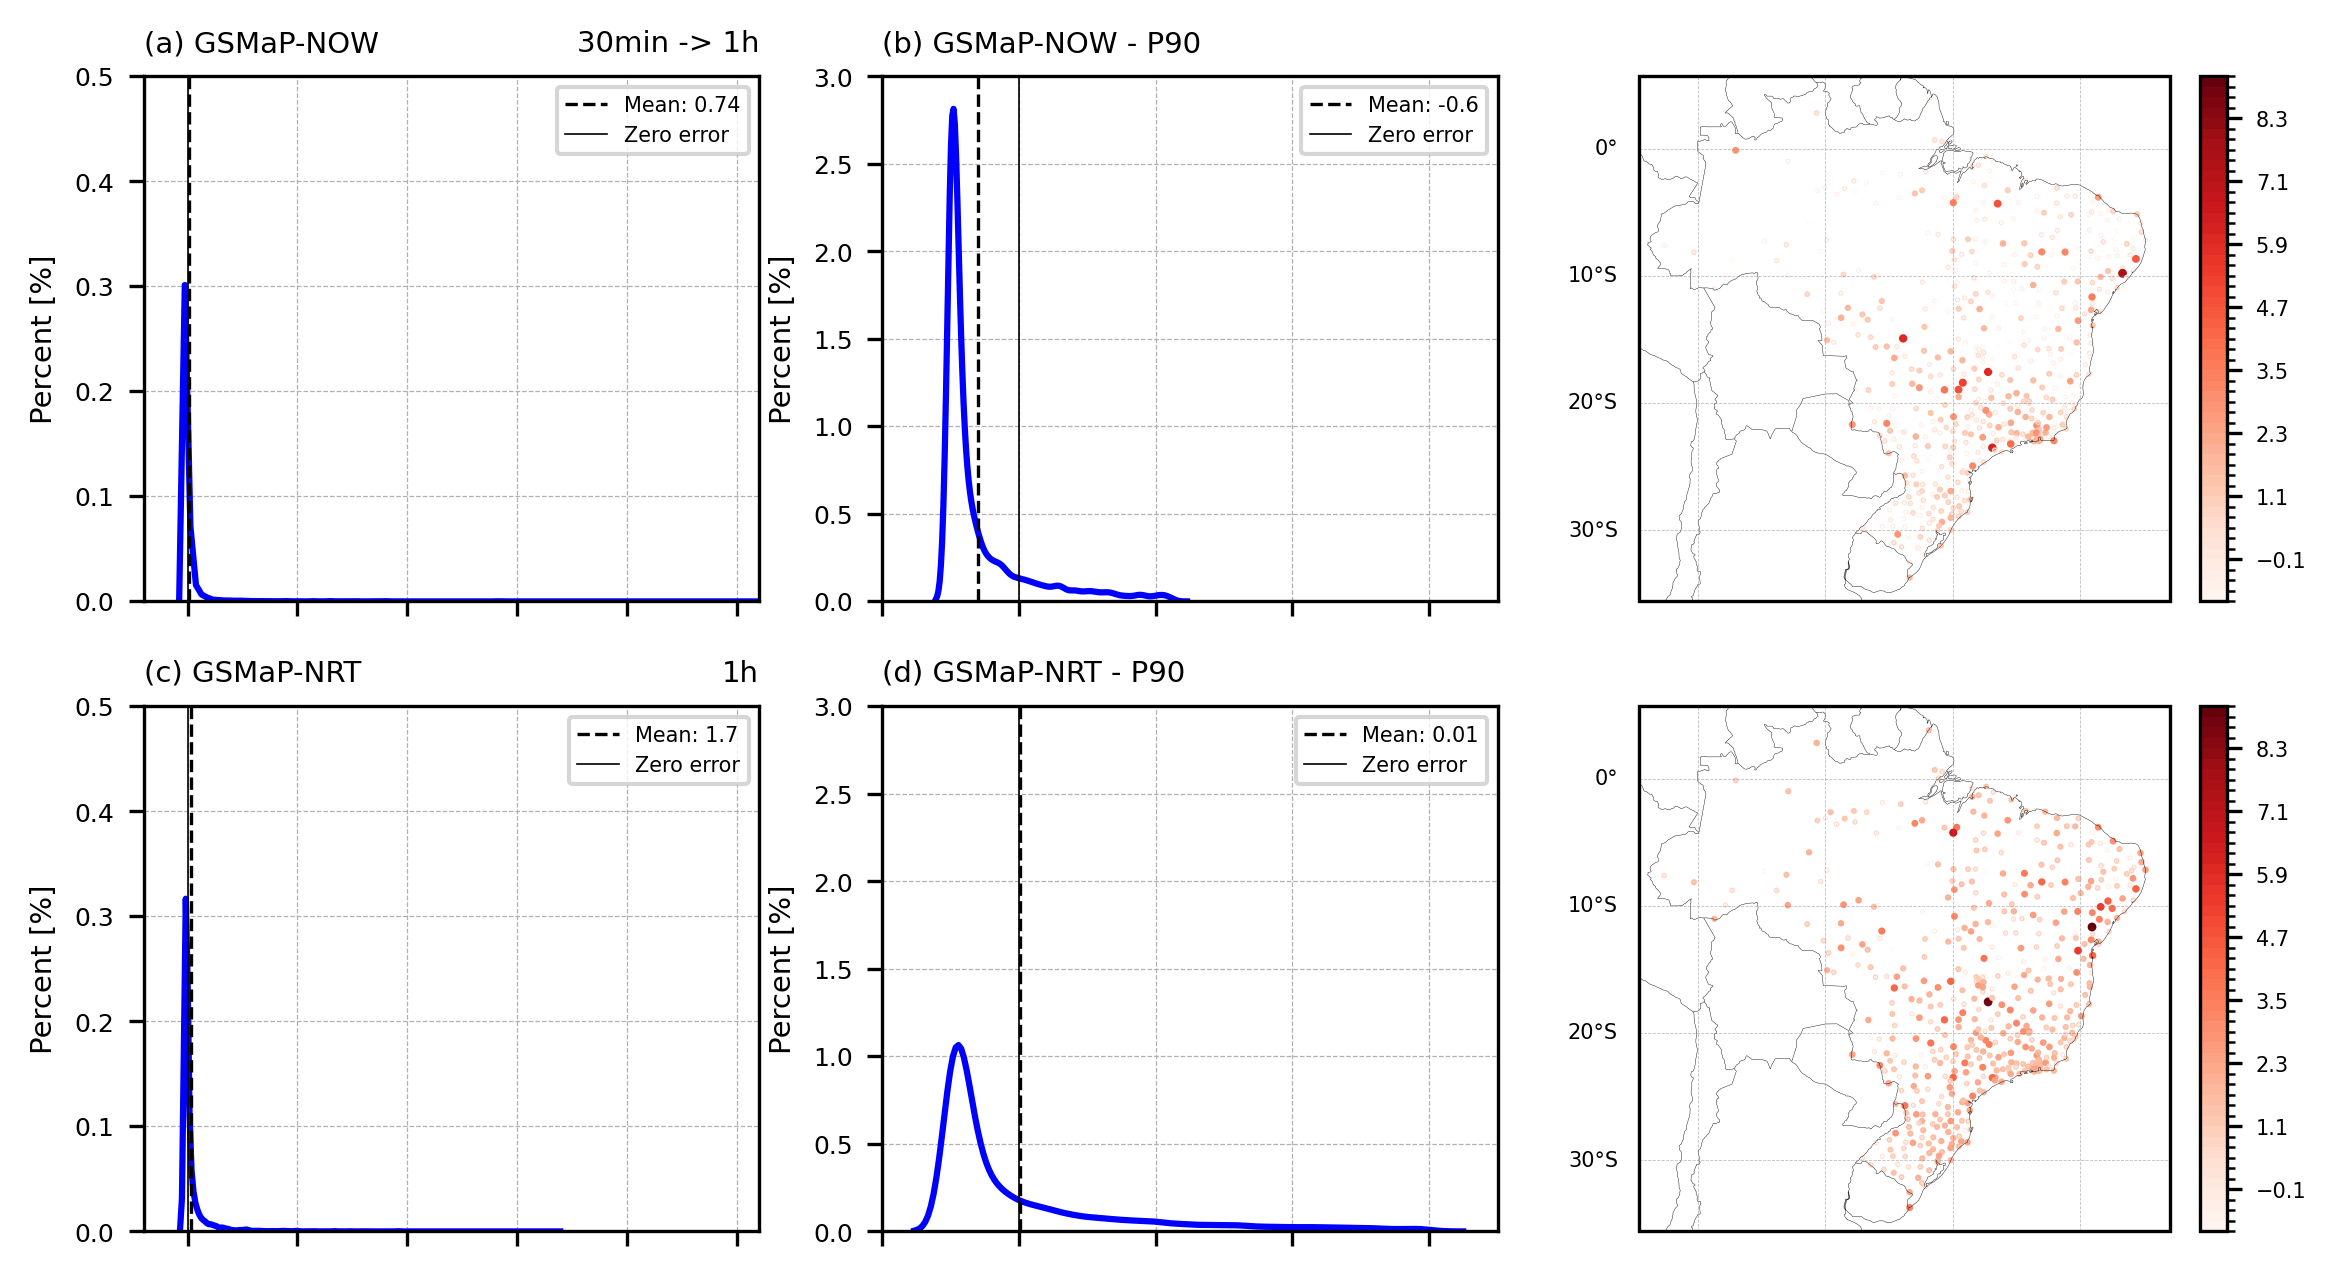

In [64]:
perc = 90

levels = np.arange(-0.9, 9.2, 0.2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Reds

fig = plt.figure(figsize=(9,5),dpi=300)
gs = gridspec.GridSpec(2,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RE_GSMaP_NOW,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RE_GSMaP_NOW),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NOW),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-20,260)
ax1.set_ylim(0,0.5)
ax1.set_xticklabels([])
ax1.set_title('(a) GSMaP-NOW', loc='left', fontsize=7)
ax1.set_title('30min -> 1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])
RE_GSMaP_NOW = np.array(RE_GSMaP_NOW)
sns.kdeplot(RE_GSMaP_NOW[RE_GSMaP_NOW<np.percentile(RE_GSMaP_NOW,perc)],color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RE_GSMaP_NOW[RE_GSMaP_NOW<np.percentile(RE_GSMaP_NOW,perc)]),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NOW[RE_GSMaP_NOW<np.percentile(RE_GSMaP_NOW,perc)]),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-2,7)
ax1.set_ylim(0,3)
ax1.set_xticklabels([])
ax1.set_title('(b) GSMaP-NOW - P90', loc='left', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MRE_GSMaP_NOW/np.nanmax(MRE_GSMaP_NOW)),marker='.',c=MRE_GSMaP_NOW,cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(RE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NRT),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
# ax1.set_xlabel('Relative Error',fontsize=7)
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-20,260)
ax1.set_ylim(0,0.5)
ax1.set_title('(c) GSMaP-NRT', loc='left', fontsize=7)
ax1.set_title('1h', loc='right', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[1, 1])
RE_GSMaP_NRT = np.array(RE_GSMaP_NRT)
sns.kdeplot(RE_GSMaP_NRT[RE_GSMaP_NRT<np.nanpercentile(RE_GSMaP_NRT,perc)],color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(RE_GSMaP_NRT[RE_GSMaP_NRT<np.nanpercentile(RE_GSMaP_NRT,perc)]),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NRT[RE_GSMaP_NRT<np.percentile(RE_GSMaP_NRT,perc)]),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
# ax1.set_xlabel('Relative Error',fontsize=7)
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-2,7)
ax1.set_ylim(0,3)
ax1.set_title('(d) GSMaP-NRT - P90', loc='left', fontsize=7)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MRE_GSMaP_NRT/np.nanmax(MRE_GSMaP_NRT)),marker='.',c=MRE_GSMaP_NRT,cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)